In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import geopandas as gp
import seaborn as sns
import scipy.integrate as spi

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
def prevalence_curves(list_districts, gamma_try, repnum):
    beta_fix = repnum * gamma_try # Transmission rate
    
    Iprevalence_df = pd.DataFrame(columns=list_districts)
    Rprevalence_df = pd.DataFrame(columns=list_districts)
    for district in list_districts: # district id the FIPS code of the hit districts
        district_nb = int(district) #FIPS code but as np int
        
        ###   Population
        N = pop.loc[district_nb].squeeze()
        #print('District: ', district_nb, ' with population: ', N)
        mob_district = mob_2020.query('county==@district_nb')

        ###   Initial conditions
        I0 = int(init_inf*N)
        S0 = N-I0
        R0 = N-S0-I0
        #print('   the initial conditions are: i(0) = ',I0, ' , s(0) = ', S0, ' , r(0) = ', R0 )

        S_prev = np.array(S0/N)
        I_prev = np.array(I0/N)
        R_prev = np.array(R0/N)

        TS=1 # Discretization timestep

        INPUT = (S0/N, I0/N, R0/N)

        for week in np.arange(0,weeks_to_observe):
            beta_mob = mob_district.query('week==(@week_fire+@week)').r.squeeze()
            beta = beta_mob*beta_fix
            #print('     at week: ', week, '  beta_mob: ', beta_mob, ' and beta fix = ', beta_fix, ' so beta: ', beta)

            t_start = 0.0; t_end = 7.0; t_inc = TS
            t_range = np.arange(t_start, t_end+t_inc, t_inc)
            #print(t_range)
            def diff_eqs(INP,t):  
                '''The main set of equations'''
                Y=np.zeros((3))
                V = INP    
                Y[0] = - beta * V[0] * V[1]
                Y[1] = beta * V[0] * V[1] - gamma_try * V[1]
                Y[2] = gamma_try * V[1]
                return Y   # For odeint

            analytical = spi.odeint(diff_eqs,INPUT,t_range)
            #print(analytical[:,1])
            INPUT = (analytical[-1,0], analytical[-1,1], analytical[-1,2])

            S_prev = np.append(S_prev, analytical[1:,0])
            I_prev = np.append(I_prev, analytical[1:,1])
            R_prev = np.append(R_prev, analytical[1:,2])

        Iprevalence_df[district] = I_prev
        Rprevalence_df[district] = R_prev
    return Iprevalence_df, Rprevalence_df

In [4]:
def prevalence_curves_masking(list_districts):
    Iprevalence = pd.DataFrame()
    Rprevalence = pd.DataFrame()

    for district in list_districts: # district id the FIPS code of the districts
        district_nb = int(district) #FIPS code but as np int

        N = pop.loc[district_nb].squeeze()

        mob_district_daily = mob_2020_day.query('county==@district_nb')
        aqi_df_district = aqi_df.query('fips_code==@district_nb')

        masking_estimates_district = masking_estimates_day.query('fips==@district')
        first_no_nan_value = masking_estimates_district[~masking_estimates_district['interp_mask_est'].isna()]['interp_mask_est'].iloc[0]
        masking_estimates_district = masking_estimates_district.fillna(first_no_nan_value)

        ###   Setting initial conditions

        I0 = int(init_inf*N) 
        S0 = N-I0
        R0 = N-S0-I0

        S_prev = np.array(S0/N)
        I_prev = np.array(I0/N)
        R_prev = np.array(R0/N)

        #print('District: ', district, '  N: ', N, ' S_0: ', S0, ' I_0: ', I0, ' R_0: ', R0)

        TS=1 # Discretization timestep
        ND=prev_days+duration # Number of days/timesteps we run the simulation

        INPUT = (S0/N, I0/N, R0/N)
        #print('INPUT________', INPUT)

        for week in range(int(ND/7)):
            #print('Day we evaluate the mobility index: ', day_fire_num-prev_days+(7*week), ' = ',dt.datetime.strptime('2020 '+str(day_fire_num-prev_days+(7*week)), '%Y %j'))
            NumDays = 7

            ###    beta_mob: changes weekly based on the mobility index
            day_week = dt.datetime.strptime('2020 '+str(day_fire_num-prev_days+(7*week)), '%Y %j')
            beta_mob = mob_district_daily.query('date==@day_week').r.squeeze()
            prop_people_masked = masking_estimates_district.query('date==@day_week').interp_mask_est.squeeze()

            t_start = 0.0; t_end = NumDays; t_inc = TS
            t_range = np.arange(t_start, t_end, t_inc)

            #print(t_start, '  ', t_end, '  ', t_inc)
            #print('t_range')
            #print(t_range)

            ###    Solving the differential equations for the week

            def diff_eqs(INP,t):  
                '''The main set of equations'''
                Y=np.zeros((3))
                V = INP    
                Y[0] = - beta * V[0] * V[1]
                Y[1] = beta * V[0] * V[1] - gamma * V[1]
                Y[2] = gamma * V[1]
                return Y   # For odeint

            for temp in t_range:
                day = dt.datetime.strptime('2020 '+str(int(day_fire_num-prev_days+(7*week)+temp)), '%Y %j')
                #print('     Day we evaluate the aqi index: ', day_fire_num-prev_days+(7*week)+temp, ' = ',day)
                if type(aqi_df_district.query('date==@day')['AQI index'].squeeze())!=np.float64:
                    aqi_daily_value = 0
                    #print('     No value in ', district, ' on the ', dt.datetime.strptime('2020 '+str(int(day_fire_num-prev_days+(7*week)+temp)), '%Y %j'))
                
                elif type(aqi_df_district.query('date==@day')['AQI index'].squeeze())==np.float64:
                    aqi_daily_value = aqi_df_district.query('date==@day')['AQI index'].squeeze()
               
                if aqi_daily_value >= threshold_air_quality:
                    reduction = (reduction_risk_mask*prop_people_masked+1-prop_people_masked)/(reduction_risk_mask*prop_people_masking_fire+1-prop_people_masking_fire)
                    beta = beta_mob*beta_fix*reduction
                else:
                    beta = beta_mob*beta_fix
                #print('     ',beta)


                analytical = spi.odeint(diff_eqs,INPUT,[temp, temp+1])
                #print('     ',analytical[:,1])
                INPUT = (analytical[-1:,0][0], analytical[-1:,1][0], analytical[-1:,2][0]) # Last point as initial condition

                S_prev = np.append(S_prev, analytical[1:,0])
                I_prev = np.append(I_prev, analytical[1:,1])
                R_prev = np.append(R_prev, analytical[1:,2])
                
        Iprevalence[district] = I_prev
        Rprevalence[district] = R_prev
    return Iprevalence, Rprevalence

# Loading data

`LOADING HIT and NOT HIT counties in WASHINGTON and OREGON`

In [5]:
districts_WA = pd.read_csv('./wildfires_project/Data/affected_counties_WA.csv', dtype=str) #Code: 53
districts_OR = pd.read_csv('./wildfires_project/Data/affected_counties_OR.csv', dtype=str) #Code: 41

In [7]:
hit_districts = list(districts_OR.county) + list(districts_WA.county)
hit_districts = [str(hit) for hit in hit_districts if str(hit) != 'nan']
print('Hit districts: ', hit_districts)

Hit districts:  ['41051', '41067', '41005', '41039', '41047', '53033', '53063', '53011', '53067', '53077']


In [8]:
no_hit_districts = list(pd.read_csv('./wildfires_project/Data/non_affected_top25pop_only2020.csv', dtype=str)['county']) # BASELINE
print('Baseline districts: ', list(no_hit_districts))

Baseline districts:  ['27137', '42003', '26147', '26163', '19013', '39025', '39035', '17019', '17031', '39049', '39061', '36005', '39085', '39095', '39099', '36029', '36047', '34001', '17111', '36055', '36059', '36061', '17119', '36065', '36071', '36081', '33011', '33015', '36087', '39165', '36103', '36119', '9005', '53057', '53061', '53073', '50007', '51069', '6037', '6041', '47009', '6057', '6059', '25001', '6073', '6089', '26065', '26077', '23005', '26081', '23019']


In [10]:
shp=gp.read_file('./wildfires_project/Data/USA_shapefile/county_level/us_shapefile_county.shp')
counties_filtered=shp[shp['pop2020']>11000]['GEO_ID'].values
shp["lat"] = shp.centroid.y
shp["lon"] = shp.centroid.x
shp=shp.sort_values(by='lat',ascending=False)
codes_rank=shp['GEO_ID'].values # ranking counties by latitutde

/var/folders/x2/vgw4xx790y58wb87xzlpylpc0000gr/T/ipykernel_31760/3124746592.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp["lat"] = shp.centroid.y
/var/folders/x2/vgw4xx790y58wb87xzlpylpc0000gr/T/ipykernel_31760/3124746592.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp["lon"] = shp.centroid.x


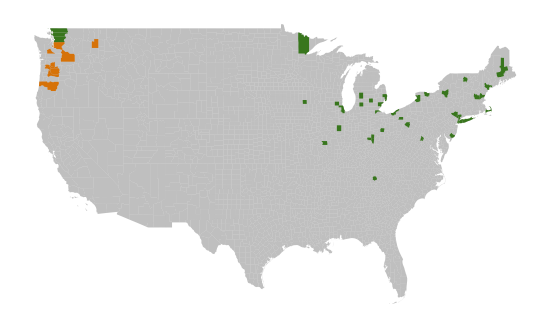

In [11]:
fig, ax1 = plt.subplots( figsize=(8,4))
shp.plot(ax = ax1, color='grey', alpha=0.5)
shp[shp['FIPS code'].isin(hit_districts)].plot(ax = ax1, color='#D67208')
shp[shp['FIPS code'].isin(no_hit_districts)].plot(ax = ax1, color='#38761D')
ax1.axis('off')
plt.show()

`LOADING CENSUS INFORMATION`

In [14]:
pop=pd.read_csv('./wildfires_project/Data/population_counties.csv')
pop=pop.set_index('GEO_ID')

`LOADING MOBILITY INDEX` 
**Weekly scale**

In [19]:
mob=pd.read_csv('./wildfires_project/Data/indoor_activity_index/indoor_activity_2018_2021_not_smoothed.csv')#.set_index('county')
mob_2020 = mob[mob['date'].str.startswith('2020')].copy()
mob_2020['date'] = pd.to_datetime(mob_2020['date'])
mob_2020['week'] = mob_2020['date'].dt.isocalendar().week.astype(np.int64)

**to Daily scale**

In [20]:
mob_2020_day = (mob_2020.set_index('date').groupby('county')['r'].resample('d').ffill().div(1).reset_index())

`AIR QUALITY INDEX` **Daily scale**

In [23]:
aqi_df = pd.read_csv('./wildfires_project/Data/data_AQI_2020.csv')
aqi_df['date'] = pd.to_datetime(aqi_df['date'])

In [24]:
hit_districts

['41051',
 '41067',
 '41005',
 '41039',
 '41047',
 '53033',
 '53063',
 '53011',
 '53067',
 '53077']

In [25]:
dis = 53011
sorted(list(set(aqi_df[aqi_df['fips_code']==dis]['date'])))

[Timestamp('2020-08-01 00:00:00'),
 Timestamp('2020-08-02 00:00:00'),
 Timestamp('2020-08-03 00:00:00'),
 Timestamp('2020-08-04 00:00:00'),
 Timestamp('2020-08-05 00:00:00'),
 Timestamp('2020-08-06 00:00:00'),
 Timestamp('2020-08-07 00:00:00'),
 Timestamp('2020-08-08 00:00:00'),
 Timestamp('2020-08-09 00:00:00'),
 Timestamp('2020-08-10 00:00:00'),
 Timestamp('2020-08-11 00:00:00'),
 Timestamp('2020-08-12 00:00:00'),
 Timestamp('2020-08-13 00:00:00'),
 Timestamp('2020-08-14 00:00:00'),
 Timestamp('2020-08-15 00:00:00'),
 Timestamp('2020-08-16 00:00:00'),
 Timestamp('2020-08-17 00:00:00'),
 Timestamp('2020-08-18 00:00:00'),
 Timestamp('2020-08-19 00:00:00'),
 Timestamp('2020-08-20 00:00:00'),
 Timestamp('2020-08-21 00:00:00'),
 Timestamp('2020-08-22 00:00:00'),
 Timestamp('2020-08-23 00:00:00'),
 Timestamp('2020-08-24 00:00:00'),
 Timestamp('2020-08-25 00:00:00'),
 Timestamp('2020-08-26 00:00:00'),
 Timestamp('2020-08-27 00:00:00'),
 Timestamp('2020-08-28 00:00:00'),
 Timestamp('2020-08-

`MASKING ESTIMATION` **Weekly scale**

In [27]:
masking_estimates = pd.read_csv('./wildfires_project/Data/interpolated_masking_estimates.csv',  dtype={'fips': str})
m = masking_estimates['fips'].str.len().max()
masking_estimates['fips'] = masking_estimates.fips.str.rjust(m ,'0' )
masking_estimates = masking_estimates[masking_estimates['week'].str.startswith('2020')].copy()
masking_estimates['week'] = pd.to_datetime(masking_estimates['week'])

In [28]:
#masking_estimates[masking_estimates['fips'].isin(hit_districts)][masking_estimates[masking_estimates['fips'].isin(hit_districts)]['week']<pd.to_datetime('2020-09-20', format='%Y-%m-%d')]

**to Daily scale**

In [29]:
masking_estimates_day = (masking_estimates.set_index('week').groupby('fips')['interp_mask_est'].resample('d').ffill().div(1).reset_index())

In [30]:
masking_estimates_day = masking_estimates_day.rename(columns = {"week": 'date'})
masking_estimates_day['week'] = masking_estimates_day['date'].dt.isocalendar().week.astype(np.int64)
masking_estimates_day['day'] = masking_estimates_day['date'].dt.isocalendar().day.astype(np.int64)

In [31]:
threshold_air_quality = 151 # Set to 1000 if no masking option
prop_people_masking_fire = 0.1
reduction_risk_mask = 0.6

`EPIDEMIC PARAMETERS`

In [32]:
inf_period = 3
gamma = 1 / inf_period # Recovery rate
Rep_numb = 1.3 # Reproductive number
beta_fix = Rep_numb * gamma # Transmission rate

init_inf = 0.01 # Initial fraction of infected people

`TEMPORAL PARAMETERS`

In [33]:
day_fire = pd.to_datetime('2020-09-10', format='%Y-%m-%d')
day_fire_num = int(day_fire.strftime('%j')) # Day of the year
prev_days = 7 # Number of days before the fire, when we start the analysis
duration = 14 # Number of weeks that we run the simulation after the fire

In [34]:
weeks_to_observe=3
week_fire = dt.date(2020, 9, 10).isocalendar().week-1  # -1 to place it before

# Simulations

`The force infection will vary depending on the indoor mobility index`

### Baseline

In [35]:
Iprevalence_baseline, Rprevalence_baseline = prevalence_curves(no_hit_districts, gamma, 3.0)
AttackRate_baseline = Iprevalence_baseline.cumsum(axis=0)

In [36]:
Incidence_baseline = pd.DataFrame(columns=no_hit_districts)
for dist in Incidence_baseline.columns:
    inc = [0]
    for step in range(1, len(Iprevalence_baseline)):
        inc.append(Iprevalence_baseline.loc[step,dist] - Iprevalence_baseline.loc[step-1, dist] +
                   Rprevalence_baseline.loc[step,dist] - Rprevalence_baseline.loc[step-1, dist])
    Incidence_baseline[dist] = inc

In [37]:
#Incidence_baseline.to_csv('./wildfires_project/Data/output_disruption/Incidence_baseline_3_0.csv', index=False, header=True)
Incidence_baseline.to_csv('./wildfires_project/Data/output_disruption/Incidence_baseline_1_5.csv', index=False, header=True)
#Incidence_baseline.to_csv('./wildfires_project/Data/output_disruption/Incidence_baseline_1_3.csv', index=False, header=True)

OSError: Cannot save file into a non-existent directory: 'wildfires_project/Data/output_disruption'

In [ ]:
AttackRate_baseline.to_csv('./wildfires_project/Data/output_disruption/AttackRate_baseline_3_0.csv', index=False, header=True)
#AttackRate_baseline.to_csv('./wildfires_project/Data/output_disruption/AttackRate_baseline_1_5.csv', index=False, header=True)
#AttackRate_baseline.to_csv('./wildfires_project/Data/output_disruption/AttackRate_baseline_1_3.csv', index=False, header=True)

### Affected counties

`No Intervention`

In [66]:
Iprevalence_hit, Rprevalence_hit = prevalence_curves(hit_districts, gamma, 1.3)
AttackRate_hit = Iprevalence_hit.cumsum(axis=0)

In [46]:
Incidence_hit = pd.DataFrame(columns=hit_districts)
for dist in Incidence_hit.columns:
    inc = [0]
    for step in range(1, len(Iprevalence_hit)):
        inc.append(Iprevalence_hit.loc[step,dist] - Iprevalence_hit.loc[step-1, dist] +
                   Rprevalence_hit.loc[step,dist] - Rprevalence_hit.loc[step-1, dist])
    Incidence_hit[dist] = inc

In [47]:
#Incidence_hit.to_csv('./wildfires_project/Data/output_disruption/Incidence_hit_3_0.csv', index=False, header=True)
Incidence_hit.to_csv('./wildfires_project/Data/output_disruption/Incidence_hit_1_5.csv', index=False, header=True)
#Incidence_hit.to_csv('./wildfires_project/Data/output_disruption/Incidence_hit_1_3.csv', index=False, header=True)

In [67]:
#AttackRate_hit.to_csv('./wildfires_project/Data/output_disruption/AttackRate_hit_3_0.csv', index=False, header=True)
#AttackRate_hit.to_csv('./wildfires_project/Data/output_disruption/AttackRate_hit_1_5.csv', index=False, header=True)
AttackRate_hit.to_csv('./wildfires_project/Data/output_disruption/AttackRate_hit_1_3.csv', index=False, header=True)

### Masking

In [68]:
Iprevalence_mask, Rprevalence_mask = prevalence_curves_masking(hit_districts)
AttackRate_mask = Iprevalence_mask.cumsum(axis=0)

In [69]:
Incidence_mask = pd.DataFrame(columns=hit_districts)
for dist in Incidence_mask.columns:
    inc = [0]
    for step in range(1, len(Iprevalence_mask)):
        inc.append(Iprevalence_mask.loc[step,dist] - Iprevalence_mask.loc[step-1, dist] +
                   Rprevalence_mask.loc[step,dist] - Rprevalence_mask.loc[step-1, dist])
    Incidence_mask[dist] = inc

In [41]:
Incidence_mask.to_csv('./wildfires_project/Data/output_disruption/Incidence_mask_1_3.csv', index=False, header=True)

In [70]:
AttackRate_mask.to_csv('./wildfires_project/Data/output_disruption/AttackRate_mask_1_3.csv', index=False, header=True)

### Relative measures

`Peak Incidence`

In [48]:
Incidence_baseline = pd.read_csv('./wildfires_project/Data/output_disruption/Incidence_baseline_1_3.csv')
Incidence_hit = pd.read_csv('./wildfires_project/Data/output_disruption/Incidence_hit_1_3.csv')

Rel_PI_1_3_df = pd.DataFrame(columns=hit_districts)
for hit in Incidence_hit.columns:
    Relative_PeakIncidence_temp = []
    for base in Incidence_baseline.columns:
        #print('Hit:', hit, ', Base:', base)
        Relative_PeakIncidence_temp.append( (np.max(Incidence_hit[hit])-np.max(Incidence_baseline[base]))/np.max(Incidence_baseline[base]) )
    Rel_PI_1_3_df[hit] = Relative_PeakIncidence_temp

In [49]:
Incidence_baseline = pd.read_csv('./wildfires_project/Data/output_disruption/Incidence_baseline_1_3.csv')
Incidence_mask = pd.read_csv('./wildfires_project/Data/output_disruption/Incidence_mask_1_3.csv')

Rel_PI_1_3_mask_df = pd.DataFrame(columns=hit_districts)
for hit in Incidence_mask.columns:
    Relative_PeakIncidence_temp = []
    for base in Incidence_baseline.columns:
        #print('Hit:', hit, ', Base:', base)
        Relative_PeakIncidence_temp.append( (np.max(Incidence_mask[hit])-np.max(Incidence_baseline[base]))/np.max(Incidence_baseline[base]) )
    Rel_PI_1_3_mask_df[hit] = Relative_PeakIncidence_temp

In [50]:
Incidence_baseline = pd.read_csv('./wildfires_project/Data/output_disruption/Incidence_baseline_1_5.csv')
Incidence_hit = pd.read_csv('./wildfires_project/Data/output_disruption/Incidence_hit_1_5.csv')

Rel_PI_1_5_df = pd.DataFrame(columns=hit_districts)
for hit in Incidence_hit.columns:
    Relative_PeakIncidence_temp = []
    for base in Incidence_baseline.columns:
        #print('Hit:', hit, ', Base:', base)
        Relative_PeakIncidence_temp.append( (np.max(Incidence_hit[hit])-np.max(Incidence_baseline[base]))/np.max(Incidence_baseline[base]) )
    Rel_PI_1_5_df[hit] = Relative_PeakIncidence_temp

In [51]:
Incidence_baseline = pd.read_csv('./wildfires_project/Data/output_disruption/Incidence_baseline_3_0.csv')
Incidence_hit = pd.read_csv('./wildfires_project/Data/output_disruption/Incidence_hit_3_0.csv')

Rel_PI_3_0_df = pd.DataFrame(columns=hit_districts)
for hit in Incidence_hit.columns:
    Relative_PeakIncidence_temp = []
    for base in Incidence_baseline.columns:
        #print('Hit:', hit, ', Base:', base)
        Relative_PeakIncidence_temp.append( (np.max(Incidence_hit[hit])-np.max(Incidence_baseline[base]))/np.max(Incidence_baseline[base]) )
    Rel_PI_3_0_df[hit] = Relative_PeakIncidence_temp

`Attack rate`

In [72]:
AttackRate_baseline = pd.read_csv('./wildfires_project/Data/output_disruption/AttackRate_baseline_1_3.csv')
AttackRate_hit = pd.read_csv('./wildfires_project/Data/output_disruption/AttackRate_hit_1_3.csv')

Rel_AR_1_3_df = pd.DataFrame(columns=hit_districts)
for hit in AttackRate_hit.columns:
    Relative_AttackRate_temp = pd.DataFrame(columns=no_hit_districts)
    for base in AttackRate_baseline.columns:
        Relative_AttackRate_temp[base] = (AttackRate_hit[hit]-AttackRate_baseline[base])/AttackRate_baseline[base]
           
    Rel_AR_1_3_df[hit] = np.array(Relative_AttackRate_temp.iloc[-1:])[0]

In [71]:
AttackRate_baseline = pd.read_csv('./wildfires_project/Data/output_disruption/AttackRate_baseline_1_3.csv')
AttackRate_mask = pd.read_csv('./wildfires_project/Data/output_disruption/AttackRate_mask_1_3.csv')

Rel_AR_1_3_mask_df = pd.DataFrame(columns=hit_districts)
for hit in AttackRate_mask.columns:
    Relative_AttackRate_temp = pd.DataFrame(columns=no_hit_districts)
    for base in AttackRate_baseline.columns:
        Relative_AttackRate_temp[base] = (AttackRate_mask[hit]-AttackRate_baseline[base])/AttackRate_baseline[base]
           
    Rel_AR_1_3_mask_df[hit] = np.array(Relative_AttackRate_temp.iloc[-1:])[0]

In [73]:
AttackRate_baseline = pd.read_csv('./wildfires_project/Data/output_disruption/AttackRate_baseline_1_5.csv')
AttackRate_hit = pd.read_csv('./wildfires_project/Data/output_disruption/AttackRate_hit_1_5.csv')

Rel_AR_1_5_df = pd.DataFrame(columns=hit_districts)
for hit in AttackRate_hit.columns:
    Relative_AttackRate_temp = pd.DataFrame(columns=no_hit_districts)
    for base in AttackRate_baseline.columns:
        Relative_AttackRate_temp[base] = (AttackRate_hit[hit]-AttackRate_baseline[base])/AttackRate_baseline[base]
           
    Rel_AR_1_5_df[hit] = np.array(Relative_AttackRate_temp.iloc[-1:])[0]

In [74]:
AttackRate_baseline = pd.read_csv('./wildfires_project/Data/output_disruption/AttackRate_baseline_3_0.csv')
AttackRate_hit = pd.read_csv('./wildfires_project/Data/output_disruption/AttackRate_hit_3_0.csv')

Rel_AR_3_0_df = pd.DataFrame(columns=hit_districts)
for hit in AttackRate_hit.columns:
    Relative_AttackRate_temp = pd.DataFrame(columns=no_hit_districts)
    for base in AttackRate_baseline.columns:
        Relative_AttackRate_temp[base] = (AttackRate_hit[hit]-AttackRate_baseline[base])/AttackRate_baseline[base]
           
    Rel_AR_3_0_df[hit] = np.array(Relative_AttackRate_temp.iloc[-1:])[0]

### Plots

In [75]:
hit_districts_names = []
for i in hit_districts:
    hit_districts_names.append(shp[shp['FIPS code']==i]['NAME'].iloc[0])
print(hit_districts_names)

['Multnomah', 'Washington', 'Clackamas', 'Lane', 'Marion', 'King', 'Spokane', 'Yakima', 'Clark', 'Thurston']


In [76]:
hit_districts_names = ['Multnomah-OR', 'Washington-OR', 'Clackamas-OR', 'Lane-OR', 'Marion-OR', 'King-WA', 'Spokane-WA', 'Yakima-WA', 'Clark-WA', 'Thurston-WA']

In [77]:
Rel_PI_1_3 = Rel_PI_1_3_df.copy()
Rel_PI_1_5 = Rel_PI_1_5_df.copy()
Rel_PI_3_0 = Rel_PI_3_0_df.copy()

Rel_PI_1_3_mask = Rel_PI_1_3_mask_df.copy()

In [78]:
Rel_AR_1_3 = Rel_AR_1_3_df.copy()
Rel_AR_1_5 = Rel_AR_1_5_df.copy()
Rel_AR_3_0 = Rel_AR_3_0_df.copy()

Rel_AR_1_3_mask = Rel_AR_1_3_mask_df.copy()

In [79]:
print('Washington: ', np.median(Rel_PI_1_3_df['41067']), ' - ', np.median(Rel_PI_1_5_df['41067']), ' - ', np.median(Rel_PI_3_0_df['41067']))
print('Yakima: ', np.median(Rel_PI_1_3_df['53077']), ' - ', np.median(Rel_PI_1_5_df['53077']), ' - ', np.median(Rel_PI_3_0_df['53077']))

Washington:  1.9823061920754341  -  1.40810162076694  -  0.30154322983573545
Yakima:  1.6474584215363057  -  1.1993552851716736  -  0.2920970808853264


In [80]:
Rel_PI_1_3.columns = hit_districts_names
Rel_PI_1_5.columns = hit_districts_names
Rel_PI_3_0.columns = hit_districts_names

Rel_PI_1_3_mask.columns = hit_districts_names

In [81]:
Rel_AR_1_3.columns = hit_districts_names
Rel_AR_1_5.columns = hit_districts_names
Rel_AR_3_0.columns = hit_districts_names

Rel_AR_1_3_mask.columns = hit_districts_names

In [82]:
Rel_PI_1_3['Reproduction Ratio'] = ['R = 1.3']*len(Rel_PI_1_3)
Rel_PI_1_5['Reproduction Ratio'] = ['R = 1.5']*len(Rel_PI_1_5)
Rel_PI_3_0['Reproduction Ratio'] = ['R = 3.0']*len(Rel_PI_3_0)

Rel_PI_1_3_mask['Reproduction Ratio'] = ['R = 1.3 \n (mask)']*len(Rel_PI_1_3_mask)

In [83]:
Rel_AR_1_3['Reproduction Ratio'] = ['R = 1.3']*len(Rel_AR_1_3)
Rel_AR_1_5['Reproduction Ratio'] = ['R = 1.5']*len(Rel_AR_1_5)
Rel_AR_3_0['Reproduction Ratio'] = ['R = 3.0']*len(Rel_AR_3_0)

Rel_AR_1_3_mask['Reproduction Ratio'] = ['R = 1.3 \n (mask)']*len(Rel_AR_1_3_mask)

In [84]:
Rel_PI_1_3 = Rel_PI_1_3.melt(id_vars=["Reproduction Ratio"], var_name="District", value_name="Value")
Rel_PI_1_5 = Rel_PI_1_5.melt(id_vars=["Reproduction Ratio"], var_name="District", value_name="Value")
Rel_PI_3_0 = Rel_PI_3_0.melt(id_vars=["Reproduction Ratio"], var_name="District", value_name="Value")

Rel_PI_1_3_mask = Rel_PI_1_3_mask.melt(id_vars=["Reproduction Ratio"], var_name="District", value_name="Value")

In [85]:
Rel_AR_1_3 = Rel_AR_1_3.melt(id_vars=["Reproduction Ratio"], var_name="District", value_name="Value")
Rel_AR_1_5 = Rel_AR_1_5.melt(id_vars=["Reproduction Ratio"], var_name="District", value_name="Value")
Rel_AR_3_0 = Rel_AR_3_0.melt(id_vars=["Reproduction Ratio"], var_name="District", value_name="Value")

Rel_AR_1_3_mask = Rel_AR_1_3_mask.melt(id_vars=["Reproduction Ratio"], var_name="District", value_name="Value")

In [86]:
data_PI = pd.concat([Rel_PI_1_3, Rel_PI_1_5, Rel_PI_3_0])
data_PI_mask =  pd.concat([ Rel_PI_1_3, Rel_PI_1_5, Rel_PI_3_0, Rel_PI_1_3_mask])

In [87]:
data_AR = pd.concat([Rel_AR_1_3, Rel_AR_1_5, Rel_AR_3_0])
data_AR_mask =  pd.concat([ Rel_AR_1_3, Rel_AR_1_5, Rel_AR_3_0, Rel_AR_1_3_mask])

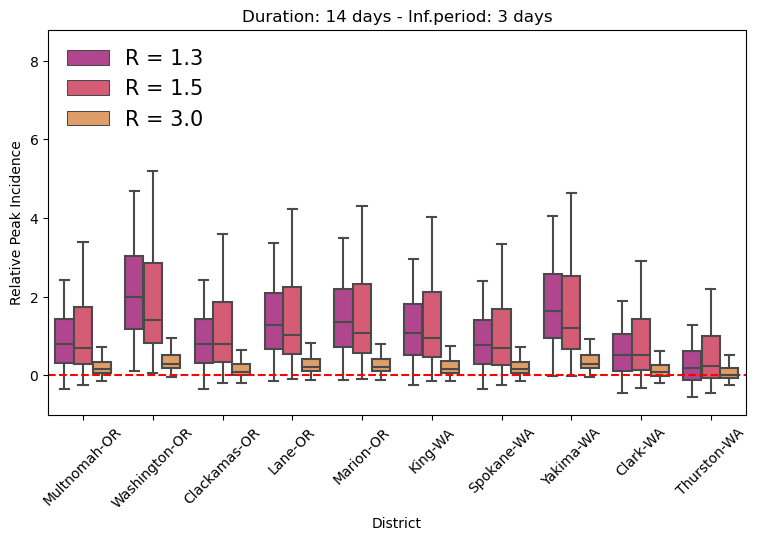

In [88]:
plt.figure(figsize=(9,5))
plt.title('Duration: 14 days - Inf.period: 3 days')
sns.boxplot(x = data_PI['District'], y = data_PI['Value'], hue = data_PI['Reproduction Ratio'],
            palette={"R = 1.5": "#EE4266", "R = 3.0": "#F99C4E", "R = 1.3": "#C53096"},
            saturation=0.7, flierprops={"marker": "x"}, fliersize=0)
plt.ylabel('Relative Peak Incidence')
plt.xticks(rotation = 45)
plt.legend(loc = 'upper left', frameon = False, fontsize=15)
plt.axhline(0,linestyle = '--', color = 'red')
plt.show()

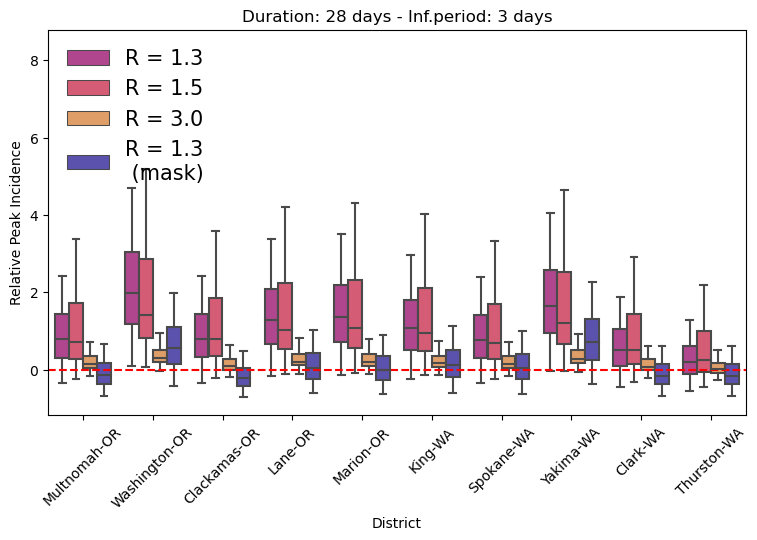

In [89]:
plt.figure(figsize=(9,5))
plt.title('Duration: 28 days - Inf.period: 3 days')
sns.boxplot(x = data_PI_mask['District'], y = data_PI_mask['Value'], hue = data_PI_mask['Reproduction Ratio'],
            palette={"R = 1.5": "#EE4266", "R = 3.0": "#F99C4E",
                     "R = 1.3": "#C53096", "R = 1.3 \n (mask)": "#4c3ec0"},
            saturation=0.7, flierprops={"marker": "x"}, fliersize=0)
plt.ylabel('Relative Peak Incidence')
plt.xticks(rotation = 45)
plt.legend(loc = 'upper left', frameon = False, fontsize=15)
plt.axhline(0,linestyle = '--', color = 'red')
plt.show()

# Generation time exploration
#### For county: '41067'

In [90]:
district_study = '41067'
district_nb = 41067

`Mobility`

In [91]:
mob_district = mob_2020.query('county==@district_nb')

`EPIDEMIC PARAMETERS`

In [92]:
# Epidemiological
Rep_numb = 1.3
gamma_vec_inv = np.arange(2,25,1)
beta_vec = np.zeros(len(gamma_vec_inv)) # Rep_numb * gamma
gamma_vec = np.zeros(len(gamma_vec_inv)) # Rep_numb * gamma

for i in range(len(gamma_vec)):
    gamma_vec[i] = 1/gamma_vec_inv[i]
    beta_vec[i] = Rep_numb*gamma_vec[i]

In [99]:
"""
   T I M E    V A R Y I N G    B E T A    B A S E L I N E
"""
Relative_PeakIncidence_by_R0 = pd.DataFrame(columns=gamma_vec_inv)
Relative_AttackRate_by_R0 = pd.DataFrame(columns=gamma_vec_inv)

count = -1
for gamma_case in gamma_vec:
    count += 1
    #print(gamma_vec_inv[count], '   ', gamma_case, '  ', beta_vec[count], '  ', beta_vec[count]/gamma_case, ' ')
    beta_case = beta_vec[count]
    ###   COMPUTING THE RESULTS FOR THE BASELINE
    Iprevalence_baseline, Rprevalence_baseline = prevalence_curves(no_hit_districts, gamma_case, 1.3)

    Iincidence_baseline = pd.DataFrame(columns=no_hit_districts)
    for dist in Iincidence_baseline.columns:
        inc = [0]
        for step in range(1, len(Iprevalence_baseline)):
            inc.append(Iprevalence_baseline.loc[step,dist] - Iprevalence_baseline.loc[step-1, dist] +
                       Rprevalence_baseline.loc[step,dist] - Rprevalence_baseline.loc[step-1, dist])
        Iincidence_baseline[dist] = inc
        
    ###   COMPUTING OUTBREAK OF THE CASE STUDY
    Iprevalence_hit, Rprevalence_hit = prevalence_curves([district_study], gamma_case, 1.3)

    Iincidence_hit = pd.DataFrame(columns=[district_study])
    for dist in Iincidence_hit.columns:
        inc = [0]
        for step in range(1, len(Iprevalence_hit)):
            inc.append(Iprevalence_hit.loc[step,dist] - Iprevalence_hit.loc[step-1, dist] +
                       Rprevalence_hit.loc[step,dist] - Rprevalence_hit.loc[step-1, dist])
        Iincidence_hit[dist] = inc
    
    peak_incidence_hit = np.max(Iincidence_hit[district_study])
    
    Relative_PeakIncidence_temp = []
    for base in Iincidence_baseline.columns:
        Relative_PeakIncidence_temp.append( (peak_incidence_hit-np.max(Iincidence_baseline[base]))/np.max(Iincidence_baseline[base]) )

    Relative_PeakIncidence_by_R0[gamma_vec_inv[count]] = Relative_PeakIncidence_temp

    
    AttackRate_baseline = Iprevalence_baseline.cumsum(axis=0)
    AttackRate_hit = Iprevalence_hit.cumsum(axis=0)
    Relative_AttackRate_temp = []
    for base in AttackRate_baseline.columns:
        Relative_AttackRate_temp.append(np.array((AttackRate_hit[district_study]-AttackRate_baseline[base])/AttackRate_baseline[base])[-1:][0])

    Relative_AttackRate_by_R0[gamma_vec_inv[count]] = Relative_AttackRate_temp

In [100]:
df_relPI_gamma = Relative_PeakIncidence_by_R0.melt()
df_relPI_gamma = df_relPI_gamma.rename(columns={"variable": "Generation time (days)", "value": "Relative Peak Incidence"})

In [101]:
df_relAR_gamma = Relative_AttackRate_by_R0.melt()
df_relAR_gamma = df_relAR_gamma.rename(columns={"variable": "Generation time (days)", "value": "Relative Attack Rate"})

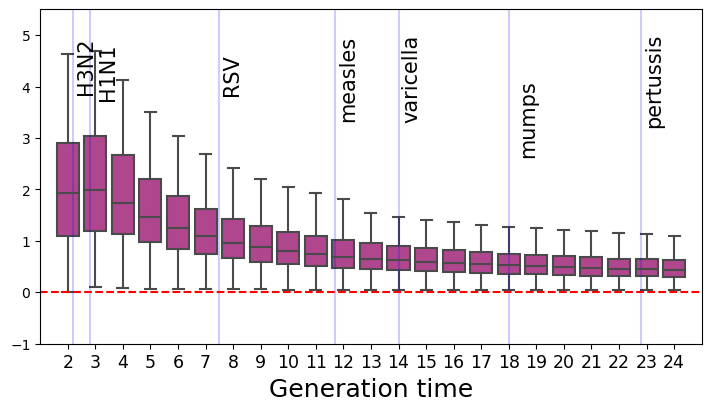

In [57]:
fig, axes = plt.subplots(1, figsize=(7,4), sharey=True, constrained_layout = True)

# Axes 1
df = Relative_PeakIncidence_by_R0.melt()
df = df.rename(columns={"variable": "Generation time", "value": "Relative Peak Incidence"})
sns.boxplot(data=df, x = 'Generation time', y = "Relative Peak Incidence", 
            color = '#C53096', saturation=0.7, flierprops={"marker": "x"}, fliersize=0,
           ax = axes)
gap = 2

axes.axvline(2.2-gap, color = 'blue', alpha=0.2)
axes.text(2.3-gap,3.92,'H3N2',rotation=90, fontsize=15)
axes.axvline(2.8-gap, color = 'blue', alpha=0.2)
axes.text(3.0-gap+0.1,3.8,'H1N1',rotation=90,  fontsize=15)
axes.axvline(7.5-gap, color = 'blue', alpha=0.2)
axes.text(7.6-gap,3.9,'RSV',rotation=90,  fontsize=15)
axes.axvline(11.7-gap, color = 'blue', alpha=0.2)
axes.text(11.8-gap,3.4,'measles',rotation=90,  fontsize=15)
axes.axvline(14-gap, color = 'blue', alpha=0.2)
axes.text(14.1-gap,3.375,'varicella',rotation=90,  fontsize=15)
axes.axvline(18-gap, color = 'blue', alpha=0.2)
axes.text(18.1-gap+0.225, 2.7,'mumps',rotation=90,  fontsize=15)
axes.axvline(22.8-gap, color = 'blue', alpha=0.2)
axes.text(22.9-gap, 3.275,'pertussis',rotation=90,  fontsize=15)

axes.axhline(0,linestyle = '--', color = 'red')
axes.set_ylabel('')
axes.set_xlabel('Generation time', fontsize=18)
axes.set_xlim(-1,23)
axes.set_ylim(-1,5.5)
axes.set_xticklabels(axes.get_xticklabels(), size=12.5)

plt.show()

/tmp/ipykernel_12834/2569904357.py:2: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipykernel_12834/2569904357.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(axes[0].get_yticklabels(), size=20)


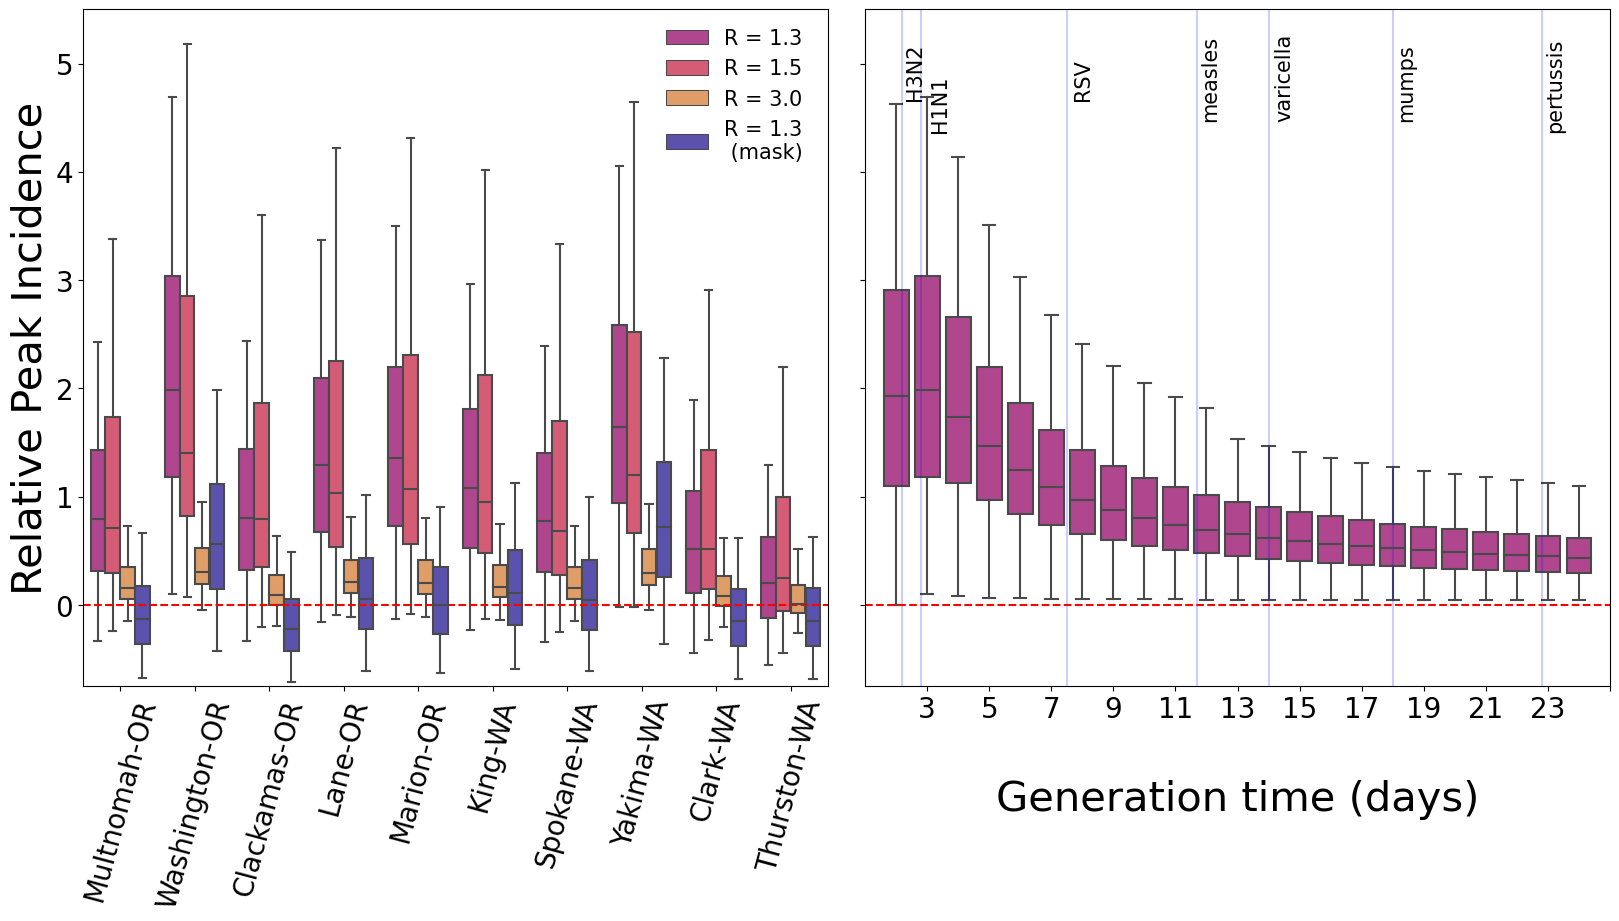

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(16,8), sharey=True, constrained_layout = True)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# Axes 0
sns.boxplot(x = data_PI_mask['District'], y = data_PI_mask['Value'], hue = data_PI_mask['Reproduction Ratio'],
            palette={"R = 1.5": "#EE4266", "R = 3.0": "#F99C4E", "R = 1.3": "#C53096", "R = 1.3 \n (mask)": "#4c3ec0"},
            saturation=0.7, flierprops={"marker": "x"}, fliersize=0, ax = axes[0])
axes[0].legend(loc = 'best', frameon = False, fontsize=15)
axes[0].axhline(0,linestyle = '--', color = 'red')
axes[0].set_ylabel('Relative Peak Incidence', fontsize=30)
axes[0].set_ylim(-0.75,5.5)
axes[0].set_xlabel('')
axes[0].set_xticklabels(axes[0].get_xticklabels(), size=20)
axes[0].set_yticklabels(axes[0].get_yticklabels(), size=20)
for tick in axes[0].get_xticklabels():
    tick.set_rotation(75)

# Axes 1
df = Relative_PeakIncidence_by_R0.melt()
df = df.rename(columns={"variable": "Generation time", "value": "Relative Peak Incidence"})
sns.boxplot(data=df, x = 'Generation time', y = "Relative Peak Incidence", 
            color = '#C53096', saturation=0.7, flierprops={"marker": "x"}, fliersize=0,
           ax = axes[1])

gap = 2
axes[1].axvline(2.2-gap, color = 'blue', alpha=0.2)
axes[1].text(2.3-gap,4.7,'H3N2',rotation=90, fontsize=15)
axes[1].axvline(2.8-gap, color = 'blue', alpha=0.2)
axes[1].text(3.0-gap+0.1,4.4,'H1N1',rotation=90,  fontsize=15)
axes[1].axvline(7.5-gap, color = 'blue', alpha=0.2)
axes[1].text(7.7-gap,4.7,'RSV',rotation=90,  fontsize=15)
axes[1].axvline(11.7-gap, color = 'blue', alpha=0.2)
axes[1].text(11.8-gap,4.5,'measles',rotation=90,  fontsize=15)
axes[1].axvline(14-gap, color = 'blue', alpha=0.2)
axes[1].text(14.2-gap,4.5,'varicella',rotation=90,  fontsize=15)
axes[1].axvline(18-gap, color = 'blue', alpha=0.2)
axes[1].text(17.9-gap+0.225, 4.5,'mumps',rotation=90,  fontsize=15)
axes[1].axvline(22.8-gap, color = 'blue', alpha=0.2)
axes[1].text(22.9-gap, 4.4,'pertussis',rotation=90,  fontsize=15)

axes[1].axhline(0,linestyle = '--', color = 'red')
axes[1].set_ylabel('')
axes[1].set_xlabel('Generation time (days)', fontsize=30, labelpad=40)
axes[1].set_xlim(-1,23)
axes[1].set_xticks(np.arange(1,25)[::2])
axes[1].set_xticklabels(axes[1].get_xticklabels(), size=20)

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()
fig.savefig("./wildfires_project/Plots/figure2_14daysobs.pdf", bbox_inches='tight')

/tmp/ipykernel_12834/2370312990.py:2: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipykernel_12834/2370312990.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(axes[0].get_yticklabels(), size=20)


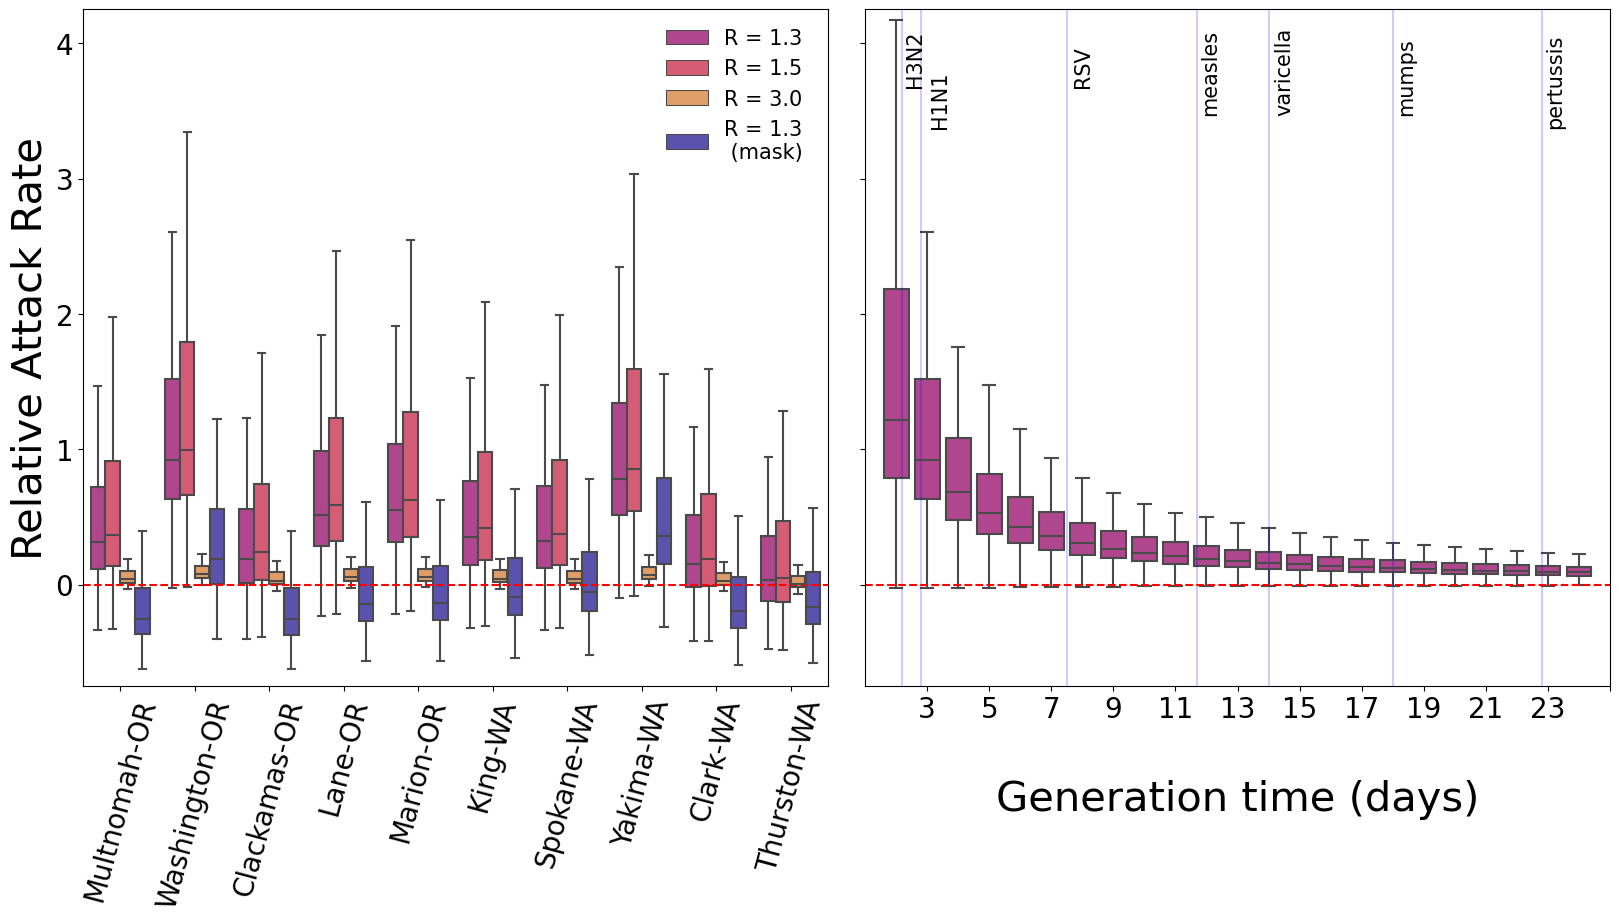

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(16,8), sharey=True, constrained_layout = True)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# Axes 0
sns.boxplot(x = data_AR_mask['District'], y = data_AR_mask['Value'], hue = data_AR_mask['Reproduction Ratio'],
            palette={"R = 1.5": "#EE4266", "R = 3.0": "#F99C4E", "R = 1.3": "#C53096", "R = 1.3 \n (mask)": "#4c3ec0"},
            saturation=0.7, flierprops={"marker": "x"}, fliersize=0, ax = axes[0])
axes[0].legend(loc = 'best', frameon = False, fontsize=15)
axes[0].axhline(0,linestyle = '--', color = 'red')
axes[0].set_ylabel('Relative Attack Rate', fontsize=30)
axes[0].set_ylim(-0.75,4.25)
axes[0].set_xlabel('')
axes[0].set_xticklabels(axes[0].get_xticklabels(), size=20)
axes[0].set_yticklabels(axes[0].get_yticklabels(), size=20)
for tick in axes[0].get_xticklabels():
    tick.set_rotation(75)

# Axes 1
df = Relative_AttackRate_by_R0.melt()
df = df.rename(columns={"variable": "Generation time", "value": "Relative Attack Rate"})
sns.boxplot(data=df, x = 'Generation time', y = "Relative Attack Rate", 
            color = '#C53096', saturation=0.7, flierprops={"marker": "x"}, fliersize=0,
           ax = axes[1])

gap = 2
axes[1].axvline(2.2-gap, color = 'blue', alpha=0.2)
axes[1].text(2.3-gap,3.7,'H3N2',rotation=90, fontsize=15)
axes[1].axvline(2.8-gap, color = 'blue', alpha=0.2)
axes[1].text(3.0-gap+0.1,3.4,'H1N1',rotation=90,  fontsize=15)
axes[1].axvline(7.5-gap, color = 'blue', alpha=0.2)
axes[1].text(7.7-gap,3.7,'RSV',rotation=90,  fontsize=15)
axes[1].axvline(11.7-gap, color = 'blue', alpha=0.2)
axes[1].text(11.8-gap,3.5,'measles',rotation=90,  fontsize=15)
axes[1].axvline(14-gap, color = 'blue', alpha=0.2)
axes[1].text(14.2-gap,3.5,'varicella',rotation=90,  fontsize=15)
axes[1].axvline(18-gap, color = 'blue', alpha=0.2)
axes[1].text(17.9-gap+0.225, 3.5,'mumps',rotation=90,  fontsize=15)
axes[1].axvline(22.8-gap, color = 'blue', alpha=0.2)
axes[1].text(22.9-gap, 3.4,'pertussis',rotation=90,  fontsize=15)

axes[1].axhline(0,linestyle = '--', color = 'red')
axes[1].set_ylabel('')
axes[1].set_xlabel('Generation time (days)', fontsize=30, labelpad = 40)
axes[1].set_xlim(-1,23)
axes[1].set_xticks(np.arange(1,25)[::2])
axes[1].set_xticklabels(axes[1].get_xticklabels(), size=20)

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()
fig.savefig("./wildfires_project/Plots/relAR_14daysobs.pdf", bbox_inches='tight')